In [1]:
import tifffile as tf
from scipy import ndimage
import numpy as np

import os
import glob
from importlib import reload

import warnings
warnings.filterwarnings( "ignore")
from matplotlib import pyplot as plt
%matplotlib inline

import walnut_utils as wnut

In [2]:
src = '../clean/'
dsts = '../shells/'
dstm = '../meats/'

walnut_batch = sorted(glob.glob( src + '*/' ))
bidx = 2
walnut_files = sorted(glob.glob(walnut_batch[bidx] + '*.tif'))
bname = walnut_batch[bidx].split('/')[-2]
wdsts = dsts + bname + '/'
if not os.path.isdir(wdsts):
    os.makedirs(wdsts)
wdstsd = wdsts + 'diagnostic/'
if not os.path.isdir(wdstsd):
    os.makedirs(wdstsd)

wdstm = dstm + bname + '/'
if not os.path.isdir(wdstm):
    os.makedirs(wdstm)
wdstmd = wdstm + 'diagnostic/'
if not os.path.isdir(wdstmd):
    os.makedirs(wdstmd)
print(wdstmd)

struc1 = ndimage.generate_binary_structure(3, 1)
struc2 = ndimage.generate_binary_structure(3, 2)

../meats/2014SBa_R5_T49/diagnostic/


In [3]:
widx = 2
print(walnut_files[widx])
img = tf.imread(walnut_files[widx])

pa, fi = os.path.split(walnut_files[widx])
fname = os.path.splitext(fi)[0]
print(fname)

../clean/2014SBa_R5_T49/003.tif
003


In [ ]:
mimg = (img).copy()

eimg = ndimage.binary_erosion(mimg, struc, 15, border_value=1)
mimg = eimg*mimg
mimg = ndimage.uniform_filter(mimg)

mimg[mimg < 120] = 0

In [ ]:
minim = ndimage.minimum_filter(mimg, size=7)

minimv = minim.flatten()
minimv = minimv[minimv > 0]

meanv = np.mean(minimv)
sdv = np.std(minimv)

print('Minimum ', meanv, sdv, meanv-2.25*sdv, sep='\t')

tminim = minim.copy()
tminim[tminim < meanv-2.25*sdv] = 0
tminim[tminim > 230] = 0

eimg = ndimage.binary_erosion(tminim, struc, 2, border_value=1)
eimg = wnut.get_largest_element(eimg)

dimg = ndimage.binary_dilation(eimg, struc, 8, border_value=0)
#dimg = ndimage.binary_erosion(dimg, struc, 3, border_value=1)

In [ ]:
meat = dimg*img
meat[meat < 120] = 0

if False:
    dmeat = meat.copy()
    dmeat = ndimage.binary_dilation(dmeat, struc, 2, border_value=0)
    dmeat = ndimage.binary_erosion(dmeat, struc, 2, border_value=1)

    meat = dmeat*img

In [ ]:
fs = 15
k = 200
ss = np.s_[:,k,:]
#ss = np.s_[50:150, k, 175:275]
    
fig, ax = plt.subplots(2,4,figsize=(16,10), sharex=True, sharey=True)
ax = np.atleast_1d(ax).flatten()

i = 0
ax[i].imshow(img[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
i = 1
ax[i].imshow(mimg[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
i = 2
ax[i].imshow(minim[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
i = 3
ax[i].imshow(tminim[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
i = 4
ax[i].imshow(eimg[ss], cmap='inferno', origin='lower', vmax=1, vmin=0)
i = 5
ax[i].imshow(dimg[ss], cmap='inferno', origin='lower', vmax=1, vmin=0)
i = 6
ax[i].imshow(meat[ss], cmap='inferno', origin='lower', vmax=1, vmin=0)
i = 7
ax[i].imshow(meat[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)

fig.suptitle(bname + '/' + fname, fontsize=fs)

fig.tight_layout()

In [ ]:
bmeat = meat.copy()
bmeat[bmeat > 0] = 1
bmeat = ndimage.binary_dilation(bmeat, struc, 1, border_value=1).astype(meat.dtype)
bmeat = ndimage.binary_erosion(bmeat, struc, 1, border_value=0).astype(meat.dtype)

fmeat = bmeat.copy()
#fmeat = wnut.fill_component(fmeat)
fmeat = ndimage.binary_fill_holes(fmeat)

diffm = fmeat - bmeat
labels,hist,numgeq1 = wnut.label_and_rearrange(diffm)

if not numgeq1:
    labels, num = ndimage.label(diffm, structure=ndimage.generate_binary_structure(img.ndim, 1))
    numholes = 0

else:
    thr = 1e-4
    numholes = np.sum(np.sort(hist)[::-1]/np.sum(bmeat) > thr)
    print(numholes)

bmeat[ labels > numholes ] = 1
meat = bmeat*img
print(hist)
print(hist.max())
print(np.sum(hist))

In [ ]:
ssrange = [150,200,250,300]

Sx = [ np.s_[k,:,:] for k in ssrange ]
Sy = [ np.s_[:,k,:] for k in ssrange ]
Sz = [ np.s_[:,:,k] for k in ssrange ]

######################################

fig, ax = plt.subplots(3,4,figsize=(16,14), sharex=True, sharey=True)
ax = np.atleast_1d(ax).flatten()

for i in range(4):
    ax[i].imshow(img[Sx[i%4]], cmap='inferno', origin='lower', vmax=255, vmin=0)
for i in range(4,8):
    ax[i].imshow(meat[Sx[i%4]], cmap='inferno', origin='lower', vmax=1, vmin=0)
for i in range(8,len(ax)):
    ax[i].imshow(meat[Sx[i%4]], cmap='inferno', origin='lower', vmax=255, vmin=0)

fig.suptitle(bname + '/' + fname + ' : x-plane meat', fontsize=fs)
fig.tight_layout()

filename = wdstmd + bname + '_' + fname + '_proc_meat_x.jpg'
plt.savefig(filename, dpi=100, format='jpg', bbox_inches = 'tight', pil_kwargs={'optimize':True})
plt.close()

################################################

fig, ax = plt.subplots(3,4,figsize=(16,14), sharex=True, sharey=True)
ax = np.atleast_1d(ax).flatten()

for i in range(4):
    ax[i].imshow(img[Sy[i%4]], cmap='inferno', origin='lower', vmax=255, vmin=0)
for i in range(4,8):
    ax[i].imshow(meat[Sy[i%4]], cmap='inferno', origin='lower', vmax=1, vmin=0)
for i in range(8,len(ax)):
    ax[i].imshow(meat[Sy[i%4]], cmap='inferno', origin='lower', vmax=255, vmin=0)

fig.suptitle(bname + '/' + fname + ' : y-plane meat', fontsize=fs)
fig.tight_layout()

filename = wdstmd + bname + '_' + fname + '_proc_meat_y.jpg'
plt.savefig(filename, dpi=100, format='jpg', bbox_inches = 'tight', pil_kwargs={'optimize':True})
plt.close()

In [ ]:
filename = wdstm + bname + '_' + fname + '_meat.tif'
print(filename)
tf.imwrite(filename, meat, photometric='minisblack', compress=3)

In [ ]:
snaps = wnut.collapse_dimensions(meat)
wnut.plot_collapse_dimensions(snaps, bname+'_'+fname, 'meat', dst=wdstmd, writefig=True, display=True)

# Shell

In [4]:
filename = wdstm + bname + '_' + fname + '_meat.tif'
meat = tf.imread(filename)

In [5]:
timg = img.copy()
timg[timg < 100] = 0
#timg = wnut.get_largest_element(timg)
timg[timg > 0] = 1

In [6]:
air = img.copy()
air[air > 100] = 0
air = wnut.get_largest_element(air)
air[air > 0] = 1
air = ndimage.binary_erosion(air, struc1, 15, border_value=0)

46125 components	 1 preserved
[24159025    53211    20602    11385     7774     7336     7076     5907
     3220     3084     2458     1682     1557     1212     1209     1041
      970      897      831      771]


In [30]:
bmeat = meat.copy()
bmeat[bmeat > 0] = 1

bmeat = ndimage.binary_dilation(bmeat, struc2, 10, border_value=0)
wmask = bmeat | timg | air

wmask = ndimage.binary_dilation(wmask, struc2, 5, border_value=0)
wmask = ndimage.binary_fill_holes(wmask)
wmask = ndimage.binary_erosion(wmask, struc1, 12, border_value=0)

In [32]:
fimg = img*wmask

fimg[fimg > 175] = 0
fimg[fimg == 0] = 2**(8*img.itemsize)-1

In [33]:
nonmeat = ~meat.astype(np.bool)
nonmeat = ndimage.binary_dilation(nonmeat, struc1, 2, border_value=0)
simg = fimg*nonmeat
simg[simg < 170] = 0

uimg = ndimage.uniform_filter(simg, (3,3,3))
uimg[uimg < 150] = 0

In [34]:
eimg = ndimage.grey_erosion(uimg, (3,3,3), mode='constant', cval = 255)
mcomp = wnut.get_largest_element(eimg)

cshell = ndimage.binary_dilation(mcomp, struc2, 5, border_value=0)
#cshell = ndimage.binary_erosion(cshell, struc1, 10, border_value=1)
#cshell = ndimage.binary_dilation(cshell, struc, 4, border_value=0)

355 components	 1 preserved
[71413134       87       58       41       22       15       14       14
       14       13        8        7        7        7        6        6
        5        5        4        4]


In [35]:
shell = img*cshell
shell[shell < 150] = 0
shell = wnut.get_largest_element(shell)

1192 components	 1 preserved
[7339859     273     184     140     125      66      65      54      51
      48      38      37      35      33      30      30      27      27
      22      21]


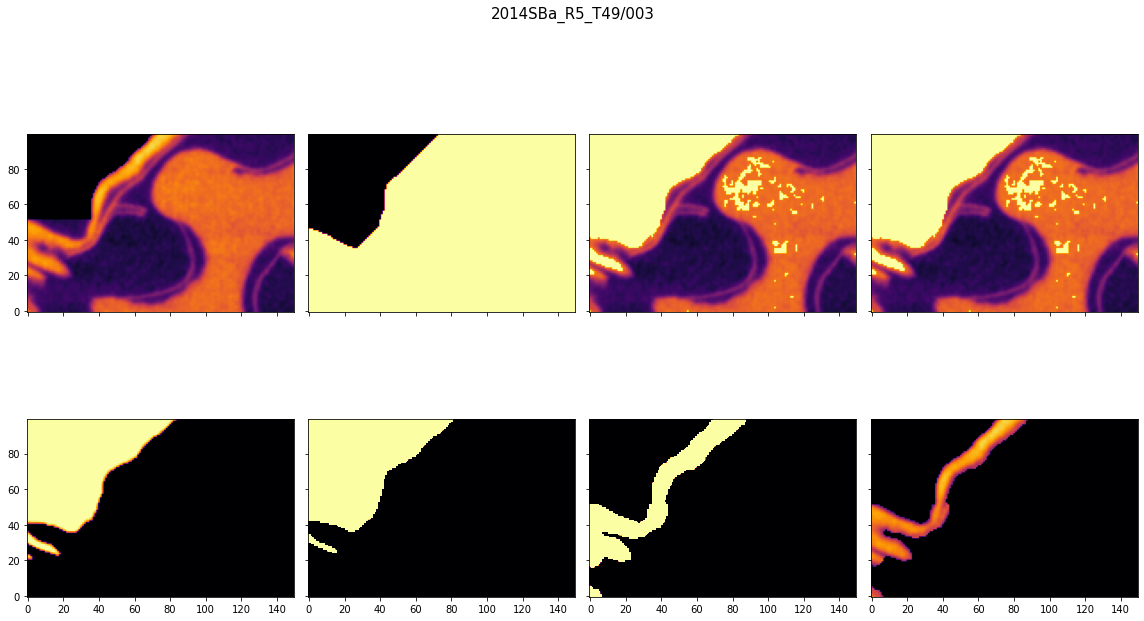

In [52]:
fs = 15
k = 200
ss = np.s_[k,300:400, 100:250]
#ss = np.s_[k,:,:]
    
fig, ax = plt.subplots(2,4,figsize=(16,10), sharex=True, sharey=True)
ax = np.atleast_1d(ax).flatten()

i = 0
ax[i].imshow(img[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
i = 1
ax[i].imshow(wmask[ss], cmap='inferno', origin='lower', vmax=1, vmin=0)
i = 2
ax[i].imshow(fimg[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
i = 3
ax[i].imshow(fimg[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
i = 4
ax[i].imshow(uimg[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
i = 5
ax[i].imshow(mcomp[ss], cmap='inferno', origin='lower', vmax=1, vmin=0)
i = 6
ax[i].imshow(shell[ss], cmap='inferno', origin='lower', vmax=1, vmin=0)
i = 7
ax[i].imshow(shell[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)

fig.suptitle(bname + '/' + fname, fontsize=fs)

fig.tight_layout()

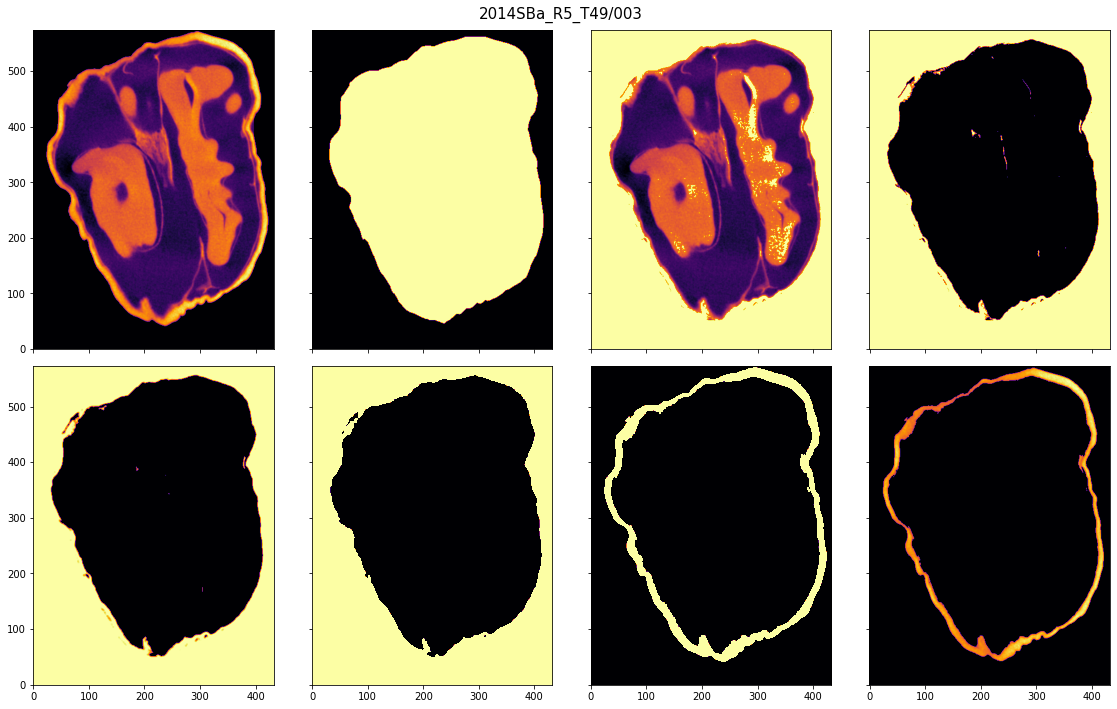

In [37]:
fs = 15
k = 300
ss = np.s_[:,k,:]
    
fig, ax = plt.subplots(2,4,figsize=(16,10), sharex=True, sharey=True)
ax = np.atleast_1d(ax).flatten()

i = 0
ax[i].imshow(img[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
i = 1
ax[i].imshow(wmask[ss], cmap='inferno', origin='lower', vmax=1, vmin=0)
i = 2
ax[i].imshow(fimg[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
i = 3
ax[i].imshow(simg[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
i = 4
ax[i].imshow(uimg[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
i = 5
ax[i].imshow(mcomp[ss], cmap='inferno', origin='lower', vmax=1, vmin=0)
i = 6
ax[i].imshow(shell[ss], cmap='inferno', origin='lower', vmax=1, vmin=0)
i = 7
ax[i].imshow(shell[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)

fig.suptitle(bname + '/' + fname, fontsize=fs)
fig.tight_layout()

In [39]:
bshell = shell.copy()
bshell[bshell > 0] = 1
bshell = ndimage.binary_dilation(bshell, struc2, 2, border_value=1).astype(shell.dtype)
bshell = ndimage.binary_erosion(bshell, struc1, 1, border_value=0).astype(shell.dtype)

fshell = bshell.copy()
fshell = ndimage.binary_fill_holes(fshell)

diffs = fshell - bshell
sdiff = np.sum(diffs)
sbshell = np.sum(bshell)
print(sdiff, sbshell, sdiff < sbshell, sep='\t')

thr = 1e-1

if sdiff == 0:
    shell = img*bshell
elif sdiff < sbshell:
    shell = img*fshell
else:
    labels,hist,numgeq1 = wnut.label_and_rearrange(diffs)
    holes = np.sum(np.sort(hist)[::-1]/np.sum(bmeat) > thr)
    print('holes', holes)
    print('max', np.max(hist))
    bshell[ labels > holes ] = 1
    shell = bshell*img

12	10160245	True


In [ ]:
fig, ax = plt.subplots(3,4,figsize=(16,14), sharex=True, sharey=True)
ax = np.atleast_1d(ax).flatten()

for i in range(4):
    ax[i].imshow(img[Sx[i%4]], cmap='inferno', origin='lower', vmax=255, vmin=0)
for i in range(4,8):
    ax[i].imshow(shell[Sx[i%4]], cmap='inferno', origin='lower', vmax=1, vmin=0)
for i in range(8,len(ax)):
    ax[i].imshow(shell[Sx[i%4]], cmap='inferno', origin='lower', vmax=255, vmin=0)

fig.suptitle(bname + '/' + fname + ' : x-plane shell', fontsize=fs)
fig.tight_layout()

filename = wdstsd + bname + '_' + fname + '_proc_shell_x.jpg'
plt.savefig(filename, dpi=100, format='jpg', bbox_inches = 'tight', pil_kwargs={'optimize':True})
plt.close()

################################################

fig, ax = plt.subplots(3,4,figsize=(16,14), sharex=True, sharey=True)
ax = np.atleast_1d(ax).flatten()

for i in range(4):
    ax[i].imshow(img[Sy[i%4]], cmap='inferno', origin='lower', vmax=255, vmin=0)
for i in range(4,8):
    ax[i].imshow(shell[Sy[i%4]], cmap='inferno', origin='lower', vmax=1, vmin=0)
for i in range(8,len(ax)):
    ax[i].imshow(shell[Sy[i%4]], cmap='inferno', origin='lower', vmax=255, vmin=0)

fig.suptitle(bname + '/' + fname + ' : y-plane shell', fontsize=fs)
fig.tight_layout()

filename = wdstsd + bname + '_' + fname + '_proc_shell_y.jpg'
plt.savefig(filename, dpi=100, format='jpg', bbox_inches = 'tight', pil_kwargs={'optimize':True})
plt.close()

In [ ]:
filename = wdsts + bname + '_' + fname + '_shell.tif'
tf.imwrite(filename, shell, photometric='minisblack', compress=3)

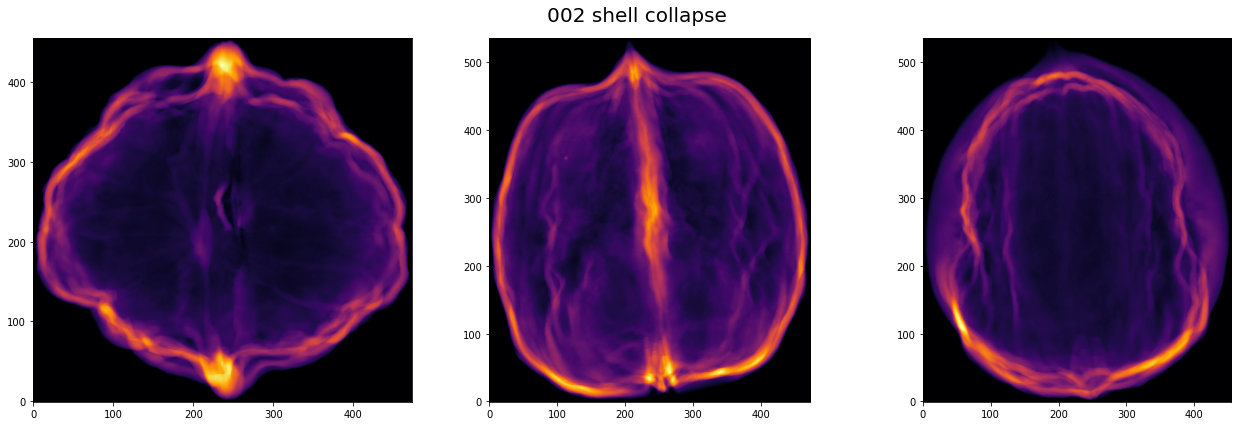

In [325]:
snaps = wnut.collapse_dimensions(shell)
wnut.plot_collapse_dimensions(snaps, fname, 'shell', dst=wdstsd, writefig=False, display=True)